# Required Background Code

In [8]:
import sqlite3
import numpy as np
from pathlib import Path
from datetime import datetime
import gsw
from itp_python.filters import pre_filter_factory


class Profile:
    def __init__(self):
        self._id = None
        self.system_number = None
        self.profile_number = None
        self.date_time = None
        self.latitude = None
        self.longitude = None
        self.pressure = None
        self.salinity = None
        self.temperature = None
        self.source = None

    def python_datetime(self):
        return datetime.strptime(self.date_time, '%Y-%m-%dT%H:%M:%S')

    def posix_time(self):
        return self.python_datetime().timestamp()

    def depth(self):
        return -self.height()

    def height(self):
        return gsw.conversions.z_from_p(self.pressure, self.latitude)

    def absolute_salinity(self):
        return gsw.conversions.SA_from_SP(
            self.salinity,
            self.pressure,
            self.longitude,
            self.latitude
        )

    def conservative_temperature(self):
        return gsw.conversions.CT_from_t(
            self.absolute_salinity(),
            self.temperature,
            self.pressure
        )

    def density(self):
        return gsw.density.rho(
            self.absolute_salinity(),
            self.conservative_temperature(),
            self.pressure
        )

    def potential_temperature(self, p_ref=0):
        return gsw.conversions.pt_from_t(
            self.absolute_salinity(),
            self.temperature,
            self.pressure,
            p_ref
        )


class ItpQuery:
    def __init__(self, db_path, **kwargs):
        self.db_path = Path(db_path)
        self.params = kwargs
        self._max_results = 5000
        self._profiles = None

    def set_max_results(self, results):
        self._max_results = results

    def set_filter_dict(self, filter_dict):
        self.params = filter_dict

    def add_filter(self, param, value):
        self.params[param] = value

    def fetch(self):
        with sqlite3.connect(str(self.db_path.absolute())) as connection:
            cursor = connection.cursor()
            self._query_metadata(cursor)
            self._query_profiles(cursor)
        return self._profiles

    def _query_metadata(self, cursor):
        results = cursor.execute(self._build_query())
        fields = [x[0] for x in results.description]
        fields[0] = '_id'
        rows = results.fetchall()
        if len(rows) > self._max_results:
            error_str = '{} results exceed maximum of {}'
            raise RuntimeError(
                error_str.format(len(rows), self._max_results))
        self._profiles = []
        for row in rows:
            this_profile = Profile()
            for field, value in zip(fields, row):
                setattr(this_profile, field, value)
            self._profiles.append(this_profile)

    def _build_query(self):
        query = 'SELECT * FROM profiles'
        if self.params:
            query += ' WHERE'
        for parameter, values in self.params.items():
            sql_filter = pre_filter_factory(parameter, values)
            if sql_filter:
                query += ' ' + sql_filter.value() + ' AND'
        if query.endswith(' AND'):
            query = query[:-4]
        query += ' ORDER BY system_number, profile_number'
        return query

    def _query_profiles(self, cursor):
        for profile in self._profiles:
            profile_id = profile._id
            fields = ['pressure', 'temperature', 'salinity']
            format_str = '{0}/10000.0 as {0}'
            query = 'SELECT '
            query += ', '.join([format_str.format(x) for x in fields])
            query += ' FROM ctd'
            query += ' WHERE profile_id = {} ORDER BY pressure'.format(
                profile_id)
            results = cursor.execute(query)
            values = np.array(results.fetchall())
            for i, field in enumerate(fields):
                setattr(profile, field, values[:, i])
                
from itp_python.itp_query import ItpQuery
from datetime import datetime
from mpl_toolkits.basemap import Basemap
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm
import pandas as pd
import numpy as np

# Query through time, location, etc for ITPs

In [ ]:
path = '/Users/emmalevin/Desktop/ITP/itp_2019_12_13.db'
startTime = datetime(2010, 1, 1)
endTime = datetime(2010, 12, 31)

# Create an ItpQuery object and load arguments through the constructor
query = ItpQuery(path, latitude=[70, 80], longitude=[-170, -140], date_time=[startTime, endTime])
# Call fetch to retrieve results
results = query.fetch()
print('{} results returned'.format(len(results)))

# Query for a specific profile number 

In [10]:
results = ItpQuery('/Users/emmalevin/Desktop/ITP/itp_2019_12_13.db', system=[4]).fetch()

# Draw map of profiler's journey and a dot for one specific profile

/Users/emmalevin/opt/anaconda3/envs/TEST/lib/python3.6/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  after removing the cwd from sys.path.


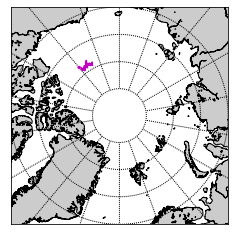

In [11]:
results = ItpQuery('/Users/emmalevin/Desktop/ITP/itp_2019_12_13.db', system=[4]).fetch()
longitude = [p.longitude for p in results]
latitude = [p.latitude for p in results]
m = Basemap(projection='npstere', boundinglat=70, lon_0=0, resolution='i')
m.drawcoastlines()
m.fillcontinents()
m.drawparallels(range(70, 90, 5))
m.drawmeridians(range(-180,180,20), latmax=85)
m.plot(longitude, latitude, color='m', latlon=True)

results = ItpQuery('/Users/emmalevin/Desktop/ITP/itp_2019_12_13.db', system=[23]).fetch()
#longitude = [p.longitude for p in results]
#latitude = [p.latitude for p in results]
m = Basemap(projection='npstere', boundinglat=70, lon_0=0, resolution='i')
m.drawcoastlines()
m.fillcontinents()
m.drawparallels(range(70, 90, 5))
m.drawmeridians(range(-180,180,20), latmax=85)
m.plot(results[1].longitude, results[1].latitude, color='b', marker = 'o', latlon=True)

# Plotting profiles

In [ ]:
import matplotlib.pyplot as plt

plt.plot(results[1].temperature, results[1].depth())
plt.gca().invert_yaxis()
plt.title('temp vs. depth')
plt.xlabel('temperature (°C)')
plt.ylabel('depth (m)')
plt.show()

plt.plot(results[1].salinity, results[1].depth())
plt.gca().invert_yaxis()
plt.title('salinity vs. depth')
plt.xlabel('salinity (PSU)')
plt.ylabel('depth (m)')
plt.show()

plt.plot(results[1].pressure, results[1].depth())
plt.gca().invert_yaxis()
plt.title('pressure vs. depth')
plt.xlabel('pressure (dbar)')
plt.ylabel('depth (m)')
plt.show()

plt.plot(results[1].potential_temperature(), results[1].depth())
plt.gca().invert_yaxis()
plt.title('potential temperature vs. depth')
plt.xlabel('pressure (dbar)')
plt.ylabel('potential temperature)')
plt.show()

# plotting multiple profilers on one graph
plt.plot(results[1].temperature, results[1].depth(), 
         results[0].temperature, results[0].depth(), 
         results[2].temperature, results[2].depth(), 
         results[3].temperature, results[3].depth(),
         results[4].temperature, results[4].depth(),
         results[5].temperature, results[5].depth()) 
plt.ylim(0, 100)
plt.gca().invert_yaxis()
plt.title('temp vs. depth')
plt.xlabel('temperature (°C)')
plt.ylabel('depth (m)')
plt.show()

# Create a dataframe 

In [ ]:
import pandas as pd


df = pd.DataFrame()
df.insert(0, "depth", results[1538].depth())
df.insert(1, "salinity", results[1538].salinity)
df.insert(2, "date/time", results[1538].date_time)
df.insert(3, "latitude", results[1538].latitude)
df.insert(4, "longitude", results[1538].longitude)
df.insert(5, "system number", results[1538].system_number)
df.insert(6, "profile number", results[1538].profile_number)
df.insert(7, "pressure", results[1538].pressure)
df.insert(8, "temperature", results[1538].temperature)

df

# Temperature vs. salinity

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

y = results2[200].potential_temperature()
y2 = results2[200].freezing_temperature_zero_pressure()
x = results2[200].salinity

ya = results[50].potential_temperature()
xa = results[50].salinity


fig = plt.figure()
ax = plt.subplot(111)

ax.plot(x, y, label='Potential temp, Canada')


ax.plot(xa, ya, label='Potential temp, Eurasia')
ax.plot(x, y2, label='Freezing temp, Eurasia')

plt.title('Temp vs. salinity')
plt.xlabel('salinity')
plt.ylabel('temperature')

ax.legend()
plt.show()

# Map of maximum potential temperature/depth of max temp/salinity of max temp of a profiler

/Users/emmalevin/opt/anaconda3/envs/TEST/lib/python3.6/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  


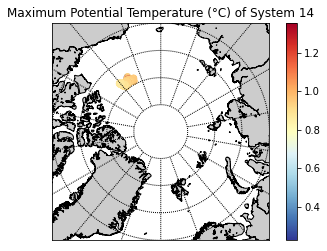

In [14]:
import matplotlib.pyplot as plt
from matplotlib import cm


number = [p.profile_number for p in results]
system = [p.system_number for p in results]
lat = [p.latitude for p in results]
lon = [p.longitude for p in results]
date = [p.date_time for p in results]

# depth at which maximum temperature occurs
depth = [p.depth()[np.argmax(p.potential_temperature())] for p in results]

# salinity of max temperature
[p.salinity[np.argmax(p.potential_temperature())] for p in results]

#maximum pot temp of a profile
maximum = [max(p.potential_temperature()) for p in results]

m = Basemap(projection='npstere', boundinglat=70, lon_0=0, resolution='i')
m.drawcoastlines()
m.fillcontinents()
m.drawparallels(range(70, 90, 5))
m.drawmeridians(range(-180,180,20), latmax=85)


m.scatter(longitude, latitude, c=maximum, cmap ='RdYlBu_r', marker = "o", latlon=True)

plt.title("Maximum Potential Temperature (°C) of System 14")
plt.colorbar()

# Histogram of max potential temp

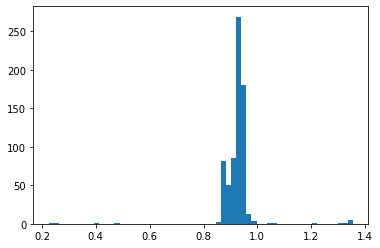

In [15]:
plt.hist(maximum, bins = 60)
plt.show()

# Creating a dataframe and eliminating faulty values

In [ ]:
number1 = [p.profile_number for p in results6]
system1 = [p.system_number for p in results6]
lat1 = [p.latitude for p in results6]
lon1 = [p.longitude for p in results6]
date1 = [p.date_time for p in results6]
maximum1 = [max(p.potential_temperature()) for p in results6]
depth1 = [p.depth()[np.argmax(p.potential_temperature())] for p in results6]
salinity1 = [p.salinity[np.argmax(p.potential_temperature())] for p in results6]

df = pd.DataFrame()
df.insert(0, "profile number", number1)
df.insert(1, "system number", system1)
df.insert(2, "latitude", lat1)
df.insert(3, "longitude", lon1)
df.insert(4, "date", date1)
df.insert(5, "max temp", maximum1)
df.insert(6, "depth", depth1)
df.insert(6, "salinity", salinity1)

dftest = df[df["salinity"] > 34]
dftest = dftest[dftest["system number"] != 48]
dftest = dftest[dftest["system number"] != 65]
dftest = dftest[(dftest['system number'] != 9) & (dftest['profile number'] != 187)]
dftest = dftest[(dftest['system number'] != 29) & (dftest['profile number'] != 1484)]
dftest = dftest[(dftest['system number'] != 17) & (dftest['profile number'] != 64)]

dftest

# Making a map of all values

In [ ]:
path = '/Users/emmalevin/Desktop/ITP/itp_2019_12_13.db'

# Create an ItpQuery object and load arguments through the constructor
query1 = ItpQuery(path, latitude=[75, 90], longitude=[-179.99, -180], date_time=[datetime(2011, 1, 1), datetime(2016, 12, 31)])
query1.set_max_results(100000)
results1 = query1.fetch()
print('{} results returned'.format(len(results1)))

number1 = [p.profile_number for p in results1]
system1 = [p.system_number for p in results1]
lat1 = [p.latitude for p in results1]
lon1 = [p.longitude for p in results1]
date1 = [p.date_time for p in results1]
maximum1 = [max(p.potential_temperature()) for p in results1]
depth1 = [p.depth()[np.argmax(p.potential_temperature())] for p in results1]
salinity1 = [p.salinity[np.argmax(p.potential_temperature())] for p in results1]

lon = dftest['longitude'].to_list()
lat = dftest['latitude'].to_list()
maximum = dftest['max temp'].to_list()
depth = dftest['depth'].to_list()
salinity = dftest['salinity'].to_list()

m = Basemap(projection='npstere', boundinglat=70, lon_0=0, resolution='i')
m.drawcoastlines()
m.fillcontinents()
m.drawparallels(range(70, 90, 5))
m.drawmeridians(range(-180,180,20), latmax=85)
m.scatter(lon, lat, c=maximum, cmap ='RdYlBu_r', vmin=0, vmax=2, marker = "o", latlon=True)
plt.title("Maximum Potential Temperature (°C) 2011-2016")
plt.colorbar()

# Separating Eurasian and Canadian Basin

In [ ]:
path = '/Users/emmalevin/Desktop/ITP/itp_2019_12_13.db'

# Create an ItpQuery object and load arguments through the constructor
# eurasian

query1 = ItpQuery(path, latitude=[75, 90], longitude=[-50, 140], date_time=[datetime(2006, 1, 1), datetime(2016, 12, 31)])
query1.set_max_results(100000)
results1 = query1.fetch()
print('{} results returned'.format(len(results1)))

#canadian

# Create an ItpQuery object and load arguments through the constructor
'''
query1 = ItpQuery(path, latitude=[75, 90], longitude=[150, -30], date_time=[datetime(2006, 1, 1), datetime(2010, 12, 31)])
query1.set_max_results(100000)
results1 = query1.fetch()
print('{} results returned'.format(len(results1)))
'''

query2 = ItpQuery(path, latitude=[75, 90], longitude=[140, -50], date_time=[datetime(2006, 1, 1), datetime(2016, 12, 31)])
query2.set_max_results(100000)
results2 = query2.fetch()
print('{} results returned'.format(len(results2)))

# Mapping the two basins

In [ ]:
longitude = [p.longitude for p in results1]
latitude = [p.latitude for p in results1]

longitude2 = [p.longitude for p in results2]
latitude2 = [p.latitude for p in results2]

m = Basemap(projection='npstere', boundinglat=70, lon_0=0, resolution='i')
m.drawcoastlines()
m.fillcontinents()
m.drawparallels(range(70, 90, 5))
m.drawmeridians(range(-180,180,20), latmax=85)
#m.plot(longitude, latitude, color='r', latlon=True)
m.scatter(longitude, latitude, color='r', marker = ".", latlon=True, label="Eurasian")
m.scatter(longitude2, latitude2, color='b', marker = ".", latlon=True, label="Canadian")
plt.legend()

# dataframe of two basins and histograms

In [ ]:
#1
number1 = [p.profile_number for p in results1]
system1 = [p.system_number for p in results1]
lat1 = [p.latitude for p in results1]
lon1 = [p.longitude for p in results1]
date1 = [p.date_time for p in results1]
maximum1 = [max(p.potential_temperature()) for p in results1]
depth1 = [p.depth()[np.argmax(p.potential_temperature())] for p in results1]
salinity1 = [p.salinity[np.argmax(p.potential_temperature())] for p in results1]

df1 = pd.DataFrame()
df1.insert(0, "profile number", number1)
df1.insert(1, "system number", system1)
df1.insert(2, "latitude", lat1)
df1.insert(3, "longitude", lon1)
df1.insert(4, "date", date1)
df1.insert(5, "max temp", maximum1)
df1.insert(6, "depth", depth1)
df1.insert(7, "salinity", salinity1)

dftest1 = df1[df1["salinity"] > 34]
dftest1 = dftest1[dftest1["system number"] != 48]
dftest1 = dftest1[dftest1["system number"] != 65]
dftest1 = dftest1[(dftest1['system number'] != 9) & (dftest1['profile number'] != 187)]
dftest1 = dftest1[(dftest1['system number'] != 29) & (dftest1['profile number'] != 1484)]
dftest1 = dftest1[(dftest1['system number'] != 17) & (dftest1['profile number'] != 64)]

#2
number2 = [p.profile_number for p in results2]
system2 = [p.system_number for p in results2]
lat2 = [p.latitude for p in results2]
lon2 = [p.longitude for p in results2]
date2 = [p.date_time for p in results2]
maximum2 = [max(p.potential_temperature()) for p in results2]
depth2 = [p.depth()[np.argmax(p.potential_temperature())] for p in results2]
salinity2 = [p.salinity[np.argmax(p.potential_temperature())] for p in results2]

df2 = pd.DataFrame()
df2.insert(0, "profile number", number2)
df2.insert(1, "system number", system2)
df2.insert(2, "latitude", lat2)
df2.insert(3, "longitude", lon2)
df2.insert(4, "date", date2)
df2.insert(5, "max temp", maximum2)
df2.insert(6, "depth", depth2)
df2.insert(7, "salinity", salinity2)

dftest2 = df2[df2["salinity"] > 34]
dftest2 = dftest2[dftest2["system number"] != 48]
dftest2 = dftest2[dftest2["system number"] != 65]
dftest2 = dftest2[(dftest2['system number'] != 9) & (dftest2['profile number'] != 187)]
dftest2 = dftest2[(dftest2['system number'] != 29) & (dftest2['profile number'] != 1484)]
dftest2 = dftest2[(dftest2['system number'] != 17) & (dftest2['profile number'] != 64)]

plt.hist(dftest1["max temp"], density = True, bins = 60, color = "grey", label = "2006-2010")
plt.hist(dftest2["max temp"], density = True, bins = 60, color = "k", label = "2011-2016")
plt.title('Maximum Temperature (°C)')
plt.xlabel('Maximum Potential Temperature (°C)')
plt.ylabel('pdf')
plt.legend()
plt.show()

plt.hist(dftest1["depth"], density = True, bins = 60, color = "grey", label = "2006-2010")
plt.hist(dftest2["depth"], density = True, bins = 60, color = "k", label = "2011-2016")
plt.title('Depth of Max Temperature (m)')
plt.xlabel('Depth (m)')
plt.ylabel('pdf')
plt.legend()
plt.show()

plt.hist(dftest1["salinity"], density = True, bins = 60, color = "grey", label = "2006-2010")
plt.hist(dftest2["salinity"], density = True, bins = 60, color = "k", label = "2011-2016")
plt.title('Salinity of Max Temperature')
plt.xlabel('Salinity')
plt.ylabel('pdf')
plt.legend()
plt.show()

# Making several different queries and mapping them

In [ ]:
path = '/Users/emmalevin/Desktop/ITP/itp_2019_12_13.db'

# Create an ItpQuery object and load arguments through the constructor
query1 = ItpQuery(path, latitude=[75, 78], longitude=[-163, -145], date_time=[datetime(2007, 1, 1), datetime(2007, 12, 31)])
query1.set_max_results(100000)
results1 = query1.fetch()
print('{} results returned'.format(len(results1)))

# Create an ItpQuery object and load arguments through the constructor
query2 = ItpQuery(path, latitude=[75, 78], longitude=[-163, -145], date_time=[datetime(2008, 1, 1), datetime(2008, 12, 31)])
query2.set_max_results(100000)
results2 = query2.fetch()
print('{} results returned'.format(len(results2)))

# Create an ItpQuery object and load arguments through the constructor
query3 = ItpQuery(path, latitude=[75, 78], longitude=[-167, -140], date_time=[datetime(2009, 1, 1), datetime(2009, 12, 31)])
query3.set_max_results(100000)
results3 = query3.fetch()
print('{} results returned'.format(len(results3)))

# Create an ItpQuery object and load arguments through the constructor
query4 = ItpQuery(path, latitude=[75, 78], longitude=[-163, -145], date_time=[datetime(2010, 1, 1), datetime(2010, 12, 31)])
query4.set_max_results(100000)
results4 = query4.fetch()
print('{} results returned'.format(len(results4)))

# Create an ItpQuery object and load arguments through the constructor
query5 = ItpQuery(path, latitude=[75, 78], longitude=[-163, -145], date_time=[datetime(2011, 1, 1), datetime(2011, 12, 31)])
query5.set_max_results(100000)
results5 = query5.fetch()
print('{} results returned'.format(len(results5)))

# Create an ItpQuery object and load arguments through the constructor
query6 = ItpQuery(path, latitude=[75, 78], longitude=[-163, -145], date_time=[datetime(2012, 1, 1), datetime(2012, 12, 31)])
query6.set_max_results(100000)
results6 = query6.fetch()
print('{} results returned'.format(len(results6)))

# Create an ItpQuery object and load arguments through the constructor
query7 = ItpQuery(path, latitude=[75, 78], longitude=[-163, -145], date_time=[datetime(2013, 1, 1), datetime(2013, 12, 31)])
query7.set_max_results(100000)
results7 = query7.fetch()
print('{} results returned'.format(len(results7)))

# Create an ItpQuery object and load arguments through the constructor
query8 = ItpQuery(path, latitude=[75, 78], longitude=[-163, -145], date_time=[datetime(2014, 1, 1), datetime(2014, 12, 31)])
query8.set_max_results(100000)
results8 = query8.fetch()
print('{} results returned'.format(len(results8)))

# Create an ItpQuery object and load arguments through the constructor
query9 = ItpQuery(path, latitude=[75, 78], longitude=[-163, -145], date_time=[datetime(2015, 1, 1), datetime(2015, 12, 31)])
query9.set_max_results(100000)
results9 = query9.fetch()
print('{} results returned'.format(len(results9)))



m = Basemap(projection='npstere', boundinglat=65, lon_0=0, resolution='i')
m.drawcoastlines()
m.fillcontinents()
m.drawparallels(range(70, 90, 5))
m.drawmeridians(range(-180,180,20), latmax=85)

m.plot(results1[50].longitude, results1[50].latitude, marker = 'o', latlon=True, label = "2007")
m.plot(results2[1].longitude, results2[1].latitude, marker = 'o', latlon=True, label = "2008")
m.plot(results3[1].longitude, results3[1].latitude, marker = 'o', latlon=True, label = "2009")
m.plot(results4[1].longitude, results4[1].latitude,  marker = 'o', latlon=True, label = "2010")
m.plot(results5[50].longitude, results5[50].latitude,  marker = 'o', latlon=True, label = "2011")
m.plot(results6[50].longitude, results6[50].latitude, marker = 'o', latlon=True, label = "2012")
m.plot(results7[50].longitude, results7[50].latitude, marker = 'o', latlon=True, label = "2013")
m.plot(results8[1].longitude, results8[1].latitude,  marker = 'o', latlon=True, label = "2014")
m.plot(results9[50].longitude, results9[50].latitude,  marker = 'o', latlon=True, label = "2015")
#m.plot(results10[50].longitude, results10[50].latitude, color='cyan', marker = 'o', latlon=True, label = "2007")

plt.legend()
#plt.title("October")

# Plotting multiple profiles on the same graph 

In [ ]:
y1 = results1[50].depth()
x1 = results1[50].potential_temperature()

y2 = results2[1].depth()
x2 = results2[1].potential_temperature()

y3 = results3[1].depth()
x3 = results3[1].potential_temperature()


y4 = results4[1].depth()
x4 = results4[1].potential_temperature()

y5 = results5[50].depth()
x5 = results5[50].potential_temperature()


y6 = results6[50].depth()
x6 = results6[50].potential_temperature()

y7 = results7[50].depth()
x7 = results7[50].potential_temperature()

y8 = results8[1].depth()
x8 = results8[1].potential_temperature()

y9 = results9[50].depth()
x9 = results9[50].potential_temperature()

fig = plt.figure()
ax = plt.subplot(111)
ax.plot(x1 , y1 , label='2007')
ax.plot(x2 + 5, y2 , label='2008')
ax.plot(x3 + 10, y3 , label='2009')
ax.plot(x4 + 15, y4 , label='2010')
ax.plot(x5 + 20, y5 , label='2011')
ax.plot(x6 + 25, y6 , label='2012')
ax.plot(x7 + 30, y7 , label='2013')
ax.plot(x8 + 35, y8 , label='2014')
ax.plot(x9 + 40 , y9 , label='2015')

plt.title('Temp vs. depth')
plt.xlabel('potential temp')
plt.ylabel('depth (m)')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#ax.legend()
plt.gca().invert_yaxis()
plt.show()

#GRAPH 2
fig = plt.figure()
ax = plt.subplot(111)
ax.plot(x1 , y1 , label='2007')
ax.plot(x2 , y2 , label='2008')
ax.plot(x3 , y3 , label='2009')
ax.plot(x4 , y4 , label='2010')
ax.plot(x5 , y5 , label='2011')
ax.plot(x6 , y6 , label='2012')
ax.plot(x7, y7 , label='2013')
ax.plot(x8 , y8 , label='2014')
ax.plot(x9 , y9 , label='2015')

plt.title('Temp vs. depth')
plt.xlabel('potential temp')
plt.ylabel('depth (m)')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#ax.legend()
plt.gca().invert_yaxis()
plt.show()

# Section of temp and salinity

### Background code

In [18]:
def cpsner(alat,alon,clat,clon):
# ================================================================
#                                              M.NAGATA <-- M.UENO
#                                         2006.06: R.Sakai for f90
#    ------------------------------------------------------------+
#    +< OUTPUT >                                                 +
#    +   RTG :  DISTANCE ALONG GREAT CIRCLE                      +
#    +          BETWEEN <A> AND <C>                              +
#    +   ANG :  ANGLE   SHOWN IN THE SCHEMATIC DIAGRAM           +
#    +                        (N)                                +
#    +                         !                                 +
#    +        270 < ANG < 360  !   180 < ANG < 270               +
#    +                         !                                 +
#    +    ------------------- (C) -----------------------        +
#    +                         !                                 +
#    +          0 < ANG <  90  !    90 < ANG < 180               +
#    +                         !                                 +
#    +                        (S)                                +
#    +< INPUT >                                                  +
#    +  ALON :  LONGITUDE OF <A>                                 +
#    +  ALAT :  LATITUDE  OF <A>                                 +
#    +  CLON :  LONGITUDE OF <C>                                 +
#    +  CLAT :  LATITUDE  OF <C>                                 +
#    +-----------------------------------------------------------+
#
  PI=asin(1.0E0)*2

  r0=6371E+3
  rad=asin(1.0E0)/90.0E0
  deg=1.0E0/float(rad)
  x1=float(clon)*float(rad)
  y1=float(clat)*float(rad)
  y1c=cos(y1)
  y1s=sin(y1)

  x2=float(alon)*rad
  y2=float(alat)*rad
  y2c=cos(y2)
  y2s=sin(y2)
  xd=x2-x1
  zc=y2c*y1c*cos(float(xd))+y2s*y1s
  zc=min([1.0E0,zc])
  zc=max([-1.0E0,zc])
  z=acos(float(zc))
  zs=sin(float(z))
  rtg=z*r0
  xd=(xd*deg+360.0E0) % 360.0E0
  if float(xd) != 0:
    alpha=(y2s-y1s*zc)/(y1c*zs)
    alpha=min([1.0E0,alpha])
    alpha=max([-1.0E0,alpha])
    alpha=acos(alpha)*deg
    if xd > 180.0E0:
       if alpha < 90.0E0:
          ang=float(alpha)+270.0E0
       if alpha >= 90.0E0:
          ang=alpha-90.0E0
    else:
      ang=270.0E0-alpha
  else:
    ang=90.0E0
    if y2 > y1 :
      ang=270.0E0
  return rtg,ang

In [19]:
def sw_dpth(p,lat):
    PI=asin(1.0E0)*2

    deg2rad = PI/180.0
    c1 = 9.72659
    c2 = -2.2512E-5
    c3 = 2.279E-10
    c4 = -1.82E-15
    gam_dash = 2.184e-6
    lat2 = abs(lat)
    x = sin(lat2*deg2rad) # convert to radians
    x = x*x
    bot_line = 9.780318*(1.0+(5.2788E-3+2.36E-5*x)*x) + gam_dash*0.5*p
    top_line = (((c4*p+c3)*p+c2)*p+c1)*p
    depth = top_line/bot_line
    return depth

In [ ]:
path = "/Users/emmalevin/Desktop/ITP/itp_2019_12_13.db"

startTime = datetime(2010, 1, 1)
endTime = datetime(2010, 12, 31)

# Create an ItpQuery object and load arguments through the constructor
query = ItpQuery(path, latitude=[70, 80], longitude=[-170, -140], date_time=[startTime, endTime])

# Call fetch to retrieve results
results = query.fetch()
print('{} results returned'.format(len(results)))

In [ ]:
nsect = len(results)
cumDistVec_track = np.zeros(nsect)
system_nums = np.zeros(nsect)

for ii, p in enumerate(results):
    system_nums[ii] = p.system_number
    if ii==0:
        lon0 = p.longitude
        lat0 = p.latitude
        cumDistVec_track[ii] = 0
        continue
    else:
        lon1 = p.longitude
        lat1 = p.latitude
        dist_, ang_ = cpsner(lat1,lon1,lat0,lon0)
        dist_ = dist_ / 1000.0 # m -> km
        cumDistVec_track[ii] = dist_
        lon0 = lon1
        lat1 = lat1
    #print (ii,lon1,lat1,dist_from_orig[ii])
print ("min dist=",cumDistVec_track.min(), "maxx dist=",cumDistVec_track.max())

In [ ]:
saltVec = []
tempVec = []
depthVec = []
cumDistVec = []

for ii, p in enumerate(results):
    saltVec.extend(p.salinity.flatten())
    tempVec.extend(p.temperature.flatten())
    dep = sw_dpth(p.pressure,p.latitude)
    depthVec.extend(dep.flatten())
    cumDistVec.extend(np.repeat(cumDistVec_track[ii], len(dep)))
    
saltVec = np.array(saltVec)
tempVec = np.array(tempVec)
depthVec = np.array(depthVec)
cumDistVec = np.array(cumDistVec)

In [ ]:
jmax = 100 # number of interpolated grids [x]
imax = 100 # number of interpolated grids [y]
depth = [0,700] # depth to draw 10m to 500m

dist = [0,cumDistVec[-1]]
distVec = np.linspace(dist[0],dist[1],imax)
depthRange = np.linspace(depth[0],depth[1],jmax)
xi, yi = np.meshgrid(distVec, depthRange)

In [ ]:
salt = griddata((cumDistVec,depthVec),saltVec,(xi.reshape(imax*jmax), yi.reshape(imax*jmax)),method='linear')
salt = salt.reshape(imax,jmax)

In [ ]:
temp = griddata((cumDistVec,depthVec),tempVec,(xi.reshape(imax*jmax), yi.reshape(imax*jmax)),method='linear')
temp = temp.reshape(imax,jmax)

In [ ]:
xi = xi.reshape(imax,jmax)
yi = yi.reshape(imax,jmax)

In [ ]:
fig, ax1, = plt.subplots(nrows=1, figsize=(8,8))

longitude = [p.longitude for p in results]
latitude = [p.latitude for p in results]
m = Basemap(projection='npstere', boundinglat=70, lon_0=0, resolution='c')
m.drawcoastlines()
m.fillcontinents()
m.drawparallels(range(70, 90, 5))
m.drawmeridians(range(-180,180,20), latmax=85)
ax1.set_title('Locations [System #=%i]' % (system_nums[0]), fontsize=14)
m.plot(longitude, latitude, latlon=True)

In [ ]:
fig, ax1, = plt.subplots(nrows=1, figsize=(12,6))
ax1.contour(xi, yi, salt, levels=14, linewidths=0.5, colors='k')
cntr1 = ax1.contourf(xi, yi, salt, levels=14, cmap="RdBu_r")
cbar = fig.colorbar(cntr1, ax=ax1)
cbar.set_label("Salinity", fontsize=12)

ax1.set_title('Salinity [System #=%i]' % (system_nums[0]), fontsize=14)
ax1.set_xlabel("Distance [km]")
ax1.set_ylabel("Depth [m]")
plt.gca().invert_yaxis()

In [ ]:
fig, ax1, = plt.subplots(nrows=1, figsize=(12,6))
ax1.contour(xi, yi, temp, levels=14, linewidths=0.5, colors='k')
cntr1 = ax1.contourf(xi, yi, temp, levels=14, cmap="RdBu_r")
cbar = fig.colorbar(cntr1, ax=ax1)
cbar.set_label("Temperature [C]", fontsize=12)
ax1.set_title('Temperature [System #=%i]' % (system_nums[0]), fontsize=14)
ax1.set_xlabel("Distance [km]")
ax1.set_ylabel("Depth [m]")
plt.gca().invert_yaxis()

# Interpolate a salinit value at 50 meters depth

In [ ]:
interp_salt = []
for p in results1:
    none_value = p.salinity == None
    if any(none_value):
        p.salinity[none_value] = np.nan
        p.salinity = p.salinity.astype('double')
    interp_salt.append(np.interp(50, p.depth(), p.salinity))

# Plot the difference between the salinity at max temp and salinity at 50 m

In [ ]:
dftest1["difference"] = dftest1["salinity"] - dftest1["salinity50"]

fig = plt.figure()
ax = plt.subplot(111)

ax.plot(dftest1["depth"], dftest1["difference"], 'o', color='black')

plt.xlabel('Depth of Maximum Temperature (m)')
plt.ylabel('s[depth of max temp] - s[50 meters]')

plt.show()

# Downloading wind data and getting winter/spring means

In [ ]:
import numpy as np
from netCDF4 import Dataset  
import numpy 
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

udata = Dataset("/Users/emmalevin/Desktop/uwnd.mon.mean.nc", "r") #name a dataset 
vdata = Dataset("/Users/emmalevin/Desktop/vwnd.mon.mean.nc", "r") #name a dataset 

#udata
#print(udata.title) 
print(udata.variables) 
#print(udata.dimensions) #prints names and size of x (lat), y (lon), and z (time) dimensions- think stacked grids 

'''
#vdata
print(vdata.title) 
print(vdata.variables) 
print(vdata.dimensions)
'''
print(udata.variables['lat'].units) #the value of a variable attribute (in this case units), can also use this method
                                  #to find out other attributes (like axis) without looking through all variables

In [ ]:
lon=udata.variables['lon'][:]  
lat=udata.variables['lat'][:]  
time=udata.variables['time'][:]
uwind=udata.variables['uwnd'][:]
vwind=vdata.variables['vwnd'][:]
speed = np.sqrt(uwind*uwind + vwind*vwind)

uwind_DJF=[]
vwind_DJF=[]

uwind_DJF2=[]
vwind_DJF2=[]

for i in range(58*12,63*12+11,12):  # djf mean for last 10 years
    uwind_DJF.append((uwind[i]+uwind[i+1]+uwind[i+2]+uwind[i+3]+uwind[i+4]+uwind[i+5]+
                      uwind[i+6]+uwind[i+7]+uwind[i+8]+uwind[i+9]+uwind[i+10]+uwind[i+11])/12)
    vwind_DJF.append((vwind[i]+vwind[i+1]+vwind[i+2]+vwind[i+3]+vwind[i+4]+vwind[i+5]+
                      vwind[i+6]+vwind[i+7]+vwind[i+8]+vwind[i+9]+vwind[i+10]+vwind[i+11])/12)
    
for i in range(64*12,69*12+11,12):  #djf mean for last 10 years
    uwind_DJF2.append((uwind[i]+uwind[i+1]+uwind[i+2]+uwind[i+3]+uwind[i+4]+uwind[i+5]+
                      uwind[i+6]+uwind[i+7]+uwind[i+8]+uwind[i+9]+uwind[i+10]+uwind[i+11])/12)
    vwind_DJF2.append((vwind[i]+vwind[i+1]+vwind[i+2]+vwind[i+3]+vwind[i+4]+vwind[i+5]+
                      vwind[i+6]+vwind[i+7]+vwind[i+8]+vwind[i+9]+vwind[i+10]+vwind[i+11])/12)
    
uwind_DJF=np.mean(uwind_DJF,axis=0) ##shape is (200,360)
vwind_DJF=np.mean(vwind_DJF,axis=0) ##shape is (200,360)

uwind_DJF2=np.mean(uwind_DJF2,axis=0) ##shape is (200,360)
vwind_DJF2=np.mean(vwind_DJF2,axis=0) ##shape is (200,360)

uwind_DJF3 = uwind_DJF2 - uwind_DJF
vwind_DJF3 = vwind_DJF2 - vwind_DJF

fig=plt.figure(figsize=(12,9))


m = Basemap(projection='npstere', boundinglat=70, lon_0=0, resolution='i')
m.drawparallels(np.arange(-90,90,30),labels=[1,0,1,0],fontsize=10)
m.drawmeridians(np.arange(-180,180,45),labels=[0,0,0,1],fontsize=10)
m.drawcoastlines()
m.fillcontinent()
m.drawstates()
m.drawcountries()


lon2d,lat2d=np.meshgrid(lon,lat)
x,y=m(lon2d,lat2d)


#m.barbs(x, y, uwind_DJF3, vwind_DJF3, length=6,
  #           sizes=dict(emptybarb=0, spacing=.2, height=0.5),
  #           zorder = 30, pivot='middle',
  #           linewidth=.95)

#m.quiver(x, y, uwind_DJF3, vwind_DJF3, scale = 60)

m.contourf(x,y,vwind_DJF3)
plt.colorbar()

plt.show()

In [ ]:
# wind barbs

lon=udata.variables['lon'][:]  
lat=udata.variables['lat'][:]  
time=udata.variables['time'][:]
uwind=udata.variables['uwnd'][:]
vwind=vdata.variables['vwnd'][:]
speed = np.sqrt(uwind*uwind + vwind*vwind)

uwind_DJF=[]
vwind_DJF=[]


for i in range(58*12,69*12+11,12):  #last 10 years
    uwind_DJF.append((uwind[i]+uwind[i+1]+uwind[i+2]+uwind[i+3]+uwind[i+4]+uwind[i+5]+uwind[i+6]+uwind[i+7]+uwind[i+8]+uwind[i+9]+uwind[i+10]+uwind[i+11])/12)
    vwind_DJF.append((vwind[i]+vwind[i+1]+vwind[i+2]+vwind[i+3]+vwind[i+4]+vwind[i+5]+vwind[i+6]+vwind[i+7]+vwind[i+8]+vwind[i+9]+vwind[i+10]+vwind[i+11])/12)

uwind_DJF=np.mean(uwind_DJF,axis=0) ##shape is (200,360)
vwind_DJF=np.mean(vwind_DJF,axis=0) ##shape is (200,360)

fig=plt.figure(figsize=(12,9))

m = Basemap(projection='npstere', boundinglat=70, lon_0=0, resolution='i')
m.drawparallels(np.arange(-90,90,30),labels=[1,0,1,0],fontsize=10)
m.drawmeridians(np.arange(-180,180,45),labels=[0,0,0,1],fontsize=10)
m.drawcoastlines()
m.drawstates()
m.drawcountries()

lon2d,lat2d=np.meshgrid(lon,lat)
x,y=m(lon2d,lat2d)

m.barbs(x, y, uwind_DJF, vwind_DJF, length=5,
             sizes=dict(emptybarb=0, spacing=.2, height=0.5),
             zorder = 20,
             linewidth=0.95)

plt.show()

In [ ]:
# more barbs

lon=udata.variables['lon'][:]  
lat=udata.variables['lat'][:]  
time=udata.variables['time'][:]
uwind=udata.variables['uflx'][:]
vwind=vdata.variables['vflx'][:]
speed = np.sqrt(uwind*uwind + vwind*vwind)

uwind_DJF=[]
vwind_DJF=[]

#u = np.zeros((uwind.shape[0],uwind.shape[1]+1),np.float64)
#u[:,0:-1] = uwind[::-1]; u[:,-1] = uwind[::-1,0]

#v = np.zeros((vwind.shape[0],vwind.shape[1]+1),np.float64)
#v[:,0:-1] = vwind[::-1]; u[:,-1] = vwind[::-1,0]


for i in range(58*12,70*12+11,12):  #last 10 years
    uwind_DJF.append((uwind[i]+uwind[i+1]+uwind[i+2]+uwind[i+3]+uwind[i+4]+uwind[i+5]+
                      uwind[i+6]+uwind[i+7]+uwind[i+8]+uwind[i+9]+uwind[i+10]+uwind[i+11])/12)
    vwind_DJF.append((vwind[i]+vwind[i+1]+vwind[i+2]+vwind[i+3]+vwind[i+4]+vwind[i+5]+
                      vwind[i+6]+vwind[i+7]+vwind[i+8]+vwind[i+9]+vwind[i+10]+vwind[i+11])/12)
    
    print(i)


uwind_DJF=np.mean(uwind_DJF,axis=0) ##shape is (200,360)
vwind_DJF=np.mean(vwind_DJF,axis=0) ##shape is (200,360)

speed = np.sqrt(uwind_DJF*uwind_DJF + vwind_DJF*vwind_DJF)

fig=plt.figure(figsize=(12,9))

m = Basemap(projection='npstere', boundinglat=70, lon_0=0, resolution='i')
m.drawparallels(np.arange(-90,90,30),labels=[1,0,1,0],fontsize=10)
m.drawmeridians(np.arange(-180,180,45),labels=[0,0,0,1],fontsize=10)
m.drawcoastlines()
m.fillcontinents()
m.drawstates()
m.drawcountries()

lon2d,lat2d=np.meshgrid(lon,lat)
x,y=m(lon2d,lat2d)

#print(lon) 



#ugrid,newlons = shiftgrid(180.,u,lon,start=False)
#vgrid,newlons = shiftgrid(180.,v,lon,start=False)

#uproj,vproj,xx,yy = \
#m.transform_vector(ugrid,vgrid,newlons,lat,31,31,returnxy=True,masked=True)

#m.barbs(x,y,uwind_DJF, vwind_DJF, length=6, sizes=dict(emptybarb=0))
#m.contourf(x,y,vwind_DJF)
#plt.colorbar()

Q = m.quiver(x, y, -uwind_DJF,-vwind_DJF, scale = 1.5)
qk = plt.quiverkey(Q, 0.1, 0.1, .1, '.1 m/s', labelpos='N')

#m.barbs(x, y, uwind_DJF, vwind_DJF, length=6,sizes=dict(emptybarb=0, spacing=.2, height=100),zorder = 30, pivot='middle', linewidth=.95)

#barbs = m.barbs(x, y, uwind_DJF, vwind_DJF,length=10,barbcolor='k',sizes=dict(emptybarb=0, spacing=.2, height=100),flagcolor='r',linewidth=0.5)
#m.quiver(x, y, uwind_DJF, vwind_DJF, latlon=True)
plt.show()

In [ ]:
# sea level pressure with wind barbs
slp = Dataset("/Users/emmalevin/Desktop/pres.sfc.mon.mean.nc", "r") #name a dataset 


lonslp=slp.variables['lon'][:]  
latslp=slp.variables['lat'][:]  
timeslp=slp.variables['time'][:]
slp =slp.variables['pres'][:]
#speed = np.sqrt(uwind*uwind + vwind*vwind)

slp_DJF =[]
slp_DJF2 =[]


for i in range(58*12+2,63*12+9,12):  #last 10 years
    slp_DJF.append((slp[i]+slp[i+1]+slp[i+2]+slp[i+3]+slp[i+4]+slp[i+5]/6)

for i in range(64*12+2,69*12+9,12):  #last 10 years
    slp_DJF2.append((slp[i]+slp[i+1]+slp[i+2]+slp[i+3]+slp[i+4]+slp[i+5]/6)


slp_DJF=np.mean(slp_DJF,axis=0) ##shape is (200,360)
slp_DJF2=np.mean(slp_DJF2,axis=0)
slp_DJF3 = slp_DJF2 - slp_DJF


fig=plt.figure(figsize=(12,9))

m = Basemap(projection='npstere', boundinglat=70, lon_0=0, resolution='i')
m.drawparallels(np.arange(-90,90,30),labels=[1,0,1,0],fontsize=10)
m.drawmeridians(np.arange(-180,180,45),labels=[0,0,0,1],fontsize=10)
m.drawcoastlines()
m.fillcontinents()
m.drawstates()
m.drawcountries()

lon2d,lat2d=np.meshgrid(lonslp,latslp)
x,y=m(lon2d,lat2d)


m.barbs(x,y,uwind_DJF, vwind_DJF, length=6, sizes=dict(emptybarb=0))
m.contourf(x,y,slp_DJF2 - slp_DJF)
plt.colorbar()
Q = m.quiver(x, y, uwind_DJF3, vwind_DJF3, scale = .5)
qk = plt.quiverkey(Q, 0.1, 0.1, .1, '.1 m/s', labelpos='N')
plt.show()

# Dissolved oxygen

In [21]:
path = '/Users/emmalevin/Desktop/ITP/itp_final_2020_06_27.db' 
query = ItpQuery(path, system=[85], extra_variables=['dissolved_oxygen'])
results = query.fetch()

### Temp vs. salinity with dissolved oxygen as the color

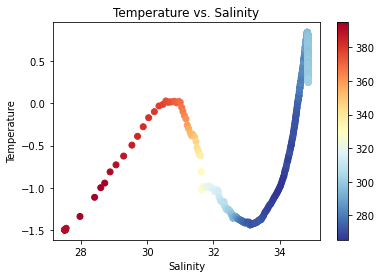

In [22]:
plt.scatter(results[0].salinity, results[0].potential_temperature(), c = results[0].dissolved_oxygen, cmap ='RdYlBu_r')

plt.title('Temperature vs. Salinity')
plt.xlabel('Salinity')
plt.ylabel('Temperature')
plt.colorbar()
plt.show()

### Minimum dissolved oxygen

In [ ]:
minimum = [min(p.dissolved_oxygen) for p in results]
m = Basemap(projection='npstere', boundinglat=70, lon_0=0, resolution='i')
m.drawcoastlines()
m.fillcontinents()
m.drawparallels(range(70, 90, 5))
m.drawmeridians(range(-180,180,20), latmax=85)
m.scatter(lon, lat, c=minimum, cmap ='RdYlBu_r', vmin = 220, vmax = 320, marker = "o", latlon=True)

plt.title("Minimum Dissolved Oxygen")
plt.colorbar()

### Dissolved oxygen vs. depth

In [ ]:
plt.plot(result1[3].dissolved_oxygen, result1[3].depth(), color = 'k')
plt.plot(result2[3].dissolved_oxygen, result2[3].depth(), color = 'b')
plt.plot(result3[3].dissolved_oxygen, result3[3].depth(), color = 'g')
#plt.plot(result4[3].dissolved_oxygen, result4[3].depth(), color = 'r')
plt.plot(result5[3].dissolved_oxygen, result5[3].depth(), color = 'm')
plt.plot(result6[650].dissolved_oxygen, result6[650].depth(), color = 'c')
plt.plot(result6[1100].dissolved_oxygen, result6[1100].depth(), color = 'y')



plt.gca().invert_yaxis()
plt.title('Dissolved Oxygen vs. Depth')
plt.xlabel('Dissolved Oxygen (μmol/kg)')
plt.ylabel('Depth (m)')
plt.show()

### Dissolved oxygen section

In [23]:
#cpsner computes the distance between points

def cpsner(alat,alon,clat,clon):
# ================================================================
#                                              M.NAGATA <-- M.UENO
#                                         2006.06: R.Sakai for f90
#    ------------------------------------------------------------+
#    +< OUTPUT >                                                 +
#    +   RTG :  DISTANCE ALONG GREAT CIRCLE                      +
#    +          BETWEEN <A> AND <C>                              +
#    +   ANG :  ANGLE   SHOWN IN THE SCHEMATIC DIAGRAM           +
#    +                        (N)                                +
#    +                         !                                 +
#    +        270 < ANG < 360  !   180 < ANG < 270               +
#    +                         !                                 +
#    +    ------------------- (C) -----------------------        +
#    +                         !                                 +
#    +          0 < ANG <  90  !    90 < ANG < 180               +
#    +                         !                                 +
#    +                        (S)                                +
#    +< INPUT >                                                  +
#    +  ALON :  LONGITUDE OF <A>                                 +
#    +  ALAT :  LATITUDE  OF <A>                                 +
#    +  CLON :  LONGITUDE OF <C>                                 +
#    +  CLAT :  LATITUDE  OF <C>                                 +
#    +-----------------------------------------------------------+
#
  PI=asin(1.0E0)*2

  r0=6371E+3
  rad=asin(1.0E0)/90.0E0
  deg=1.0E0/float(rad)
  x1=float(clon)*float(rad)
  y1=float(clat)*float(rad)
  y1c=cos(y1)
  y1s=sin(y1)

  x2=float(alon)*rad
  y2=float(alat)*rad
  y2c=cos(y2)
  y2s=sin(y2)
  xd=x2-x1
  zc=y2c*y1c*cos(float(xd))+y2s*y1s
  zc=min([1.0E0,zc])
  zc=max([-1.0E0,zc])
  z=acos(float(zc))
  zs=sin(float(z))
  rtg=z*r0
  xd=(xd*deg+360.0E0) % 360.0E0
  if float(xd) != 0:
    alpha=(y2s-y1s*zc)/(y1c*zs)
    alpha=min([1.0E0,alpha])
    alpha=max([-1.0E0,alpha])
    alpha=acos(alpha)*deg
    if xd > 180.0E0:
       if alpha < 90.0E0:
          ang=float(alpha)+270.0E0
       if alpha >= 90.0E0:
          ang=alpha-90.0E0
    else:
      ang=270.0E0-alpha
  else:
    ang=90.0E0
    if y2 > y1 :
      ang=270.0E0
  return rtg,ang

In [24]:
#sw_depth computes the depth from pressure and latitude

def sw_dpth(p,lat):
    PI=asin(1.0E0)*2

    deg2rad = PI/180.0
    c1 = 9.72659
    c2 = -2.2512E-5
    c3 = 2.279E-10
    c4 = -1.82E-15
    gam_dash = 2.184e-6
    lat2 = abs(lat)
    x = sin(lat2*deg2rad) # convert to radians
    x = x*x
    bot_line = 9.780318*(1.0+(5.2788E-3+2.36E-5*x)*x) + gam_dash*0.5*p
    top_line = (((c4*p+c3)*p+c2)*p+c1)*p
    depth = top_line/bot_line
    return depth

In [25]:
#main, read data

path = '/Users/emmalevin/Desktop/ITP/itp_final_2020_06_27.db' 
query = ItpQuery(path, system=[69], extra_variables=['dissolved_oxygen'])
results = query.fetch()

/Users/emmalevin/opt/anaconda3/envs/TEST/lib/python3.6/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  import sys


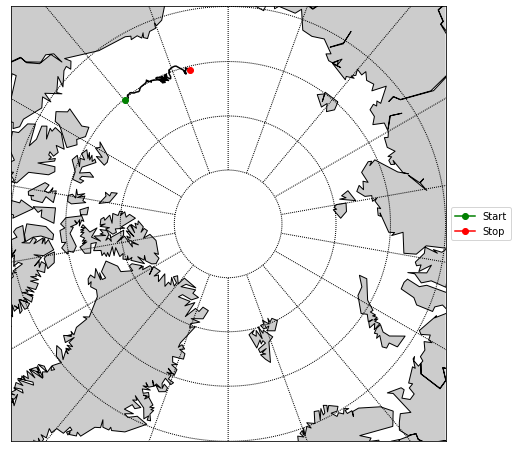

In [26]:
fig, ax, = plt.subplots(nrows=1, figsize=(8,8))

#results = ItpQuery('/Users/emmalevin/Desktop/ITP/itp_2019_12_13.db', system=[17]).fetch()
#print('{} results returned'.format(len(results)))
longitude = [p.longitude for p in results]
latitude = [p.latitude for p in results]
m = Basemap(projection='npstere', boundinglat=70, lon_0=0, resolution='c')
m.drawcoastlines()
m.fillcontinents()
m.drawparallels(range(70, 90, 5))
m.drawmeridians(range(-180,180,20), latmax=85)
m.plot(longitude, latitude, color='k', latlon=True)
m.plot(results[0].longitude, results[0].latitude, color='g', marker = 'o', latlon=True, label = "Start")
m.plot(results[-1].longitude, results[-1].latitude, color='r', marker = 'o', latlon=True, label = "Stop")
plt.legend(loc='upper center')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [ ]:
#accumulated distance from starting point

nsect = len(results)
cumDistVec_track = np.zeros(nsect)
system_nums = np.zeros(nsect)

for ii, p in enumerate(results):
    system_nums[ii] = p.system_number
    if ii==0:
        lon0 = p.longitude
        lat0 = p.latitude
        cumDistVec_track[ii] = 0
        continue
    else:
        lon1 = p.longitude
        lat1 = p.latitude
        dist_, ang_ = cpsner(lat1,lon1,lat0,lon0)
        dist_ = dist_ / 1000.0 # m -> km
        cumDistVec_track[ii] = cumDistVec_track[ii-1] + dist_
        lon0 = lon1
        lat0 = lat1
    #print (ii,lon1,lat1,dist_from_orig[ii])
print ("min dist=",cumDistVec_track.min(), "maxx dist=",cumDistVec_track.max())

In [ ]:
#reading variables

saltVec = []
tempVec = []
depthVec = []
oxygenVec = []
cumDistVec = []

for ii, p in enumerate(results):
    saltVec.extend(p.salinity.flatten())
    tempVec.extend(p.temperature.flatten())
    oxygenVec.extend(p.dissolved_oxygen.flatten())
    dep = sw_dpth(p.pressure,p.latitude)
    depthVec.extend(dep.flatten())
    cumDistVec.extend(np.repeat(cumDistVec_track[ii], len(dep)))
    
saltVec = np.array(saltVec)
tempVec = np.array(tempVec)
depthVec = np.array(depthVec)
oxygenVec = np.array(oxygenVec)
cumDistVec = np.array(cumDistVec)

In [ ]:
#interpolating grid

jmax = 100 # number of interpolated grids [x]
imax = 100 # number of interpolated grids [y]
depth = [10,400] # depth to draw 10m to 500m

dist = [0,cumDistVec[-1]]
distVec = np.linspace(dist[0],dist[1],imax)
depthRange = np.linspace(depth[0],depth[1],jmax)
xi, yi = np.meshgrid(distVec, depthRange)

In [ ]:
# interpolate oxygen 

oxygen = griddata((cumDistVec,depthVec),oxygenVec,(xi.reshape(imax*jmax), yi.reshape(imax*jmax)),method='linear')
oxygen = oxygen.reshape(imax,jmax)

In [ ]:
#redefine interpolated grid

xi = xi.reshape(imax,jmax)
yi = yi.reshape(imax,jmax)

In [ ]:
# draw salinity 

fig, ax1, = plt.subplots(nrows=1, figsize=(12,6))
ax1.contour(xi, yi, oxygen, levels=14, linewidths=0.5, colors='k')
cntr1 = ax1.contourf(xi, yi, oxygen, levels=14, cmap="RdBu_r")
cbar = fig.colorbar(cntr1, ax=ax1)
cbar.set_label("Dissolved Oxygen", fontsize=12)

ax1.set_title('Dissolved Oxygen [ITP%i]' % (system_nums[0]), fontsize=14)
ax1.set_xlabel("Distance [km]")
ax1.set_ylabel("Depth [m]")
plt.gca().invert_yaxis()